# PCA
This notebook can be used to do PCA on the following things:
- Sound speed and equation of state of the dark sector in the 2-fluid model
- Sound speed and equation of state of dark matter and neutrinos in the 3-fluid model
- Standard cosmological parameters in the 3-fluid model


In [2]:
# third party imports
import numpy as np
from numpy import exp, log, log10, sqrt, zeros, ones, linspace
import matplotlib.pyplot as plt
import numba
import pickle

# other project files
import modes
import spectra

In [3]:
# numerical parameters
NT = 4000
NT = 2**14
NK = 400
NX = 10000
L_MAX = 2500
xmin = 0.01
xmax = 3000
a0 = 1.e-6
a0_pca = 5.e-5
a_rec = 1/1100

# arrays
A = np.linspace(a0, a_rec, 2*NT)
K = np.linspace(.1, 3000, NK)
L = np.array([i for i in range(2, 50, 1)]+[i for i in range(50, 200, 5)] +
                  [i for i in range(200, L_MAX+1, 20)])
L_eval = np.arange(2, L_MAX+1)
NL = len(L)
X = np.linspace(xmin, xmax, NX)
JLX, DJLX = spectra.get_bessels(L, X)

Bessel functions loaded from file.


# 3-fluid  model
The function params_PCA below gets the fisher matrix for the scalar-valued parameters in the 3-fluid model. Equation of state and sound speed for CDM and neutrinos are treated as scalar parameters (they aren't allowed to depend on time or wavenumber).

In [4]:
# physical parameters
h = 0.6774
As = np.exp(3.064)/1.e10 # scalar perturbation amplitude
TCMB0 = 2.72548 * 1.e6 # CMB temp (microK)
OmegaM0 = 0.3089
OmegaB0 = 0.0486
OmegaR0 = 4.2e-5/h**2
OmegaN0 = OmegaR0*(1-1/1.68)
OmegaG0 = OmegaR0 - OmegaN0
OmegaC0 = OmegaM0 - OmegaB0
wC = np.zeros(2*NT)
wN = np.ones(2*NT)*1/3
cs2C = np.zeros((2*NT, NK))
cs2N = np.ones((2*NT, NK))*1/3
params_F = [wC, cs2C, wN, cs2N, OmegaB0, OmegaC0, OmegaG0, OmegaN0, As, TCMB0, h]

Cl = spectra.get_Cl_3fld(L, L_eval, X, JLX, DJLX, A, K, *params_F)
err = spectra.get_Cl_err(L_eval,Cl)
Sigma = np.diag(err**2)

def params_PCA(t):
    """Fisher matrix for density parameters, equation of state, sound speed."""

    NC = len(params_F) #number of parameters
    ss = 0.1**t #(derivative step size)
    B = np.eye(NC)
    J = np.zeros((len(L_eval), NC))

    print('computing derivatives (t='+str(t)+')')
    # take the central-difference derivatives with respect to each parameter
    for n in range(NC):
        params_fwd = params_F + ss*B[n]
        params_bwd = params_F - ss*B[n]
        Cl_fwd  = spectra.get_Cl_3fld(A, K, *params_fwd)
        Cl_bwd = spectra.get_Cl_3fld(A, K, *params_bwd)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
            
    # save the derivatives
    pickle.dump(J, open("output/params/J_t-"+str(t)+".p", "wb"))
    print('\n','derivatives saved (t='+str(t)+')')
    
    F = J.T@np.linalg.inv(Sigma)@J
    pickle.dump(F, open("output/params/F_t-"+str(t)+".p", "wb"))
    print('\n','Fisher matrix saved (t='+str(t)+')')
    
#params_PCA(7)

#  2-fluid model
Below are functions to do PCA on the equation of state and the sound speed of the dark sector in the two fluid model

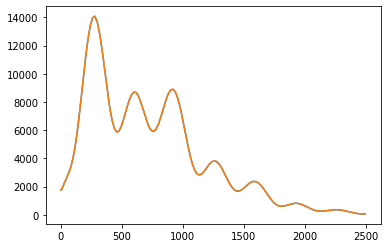

In [5]:
"""Get the fiduciary parameters for the 2-fluid model"""

# solve for perturbation history using 3-fluid model.
Y, TAU = modes.solve_3fld(A, K, wC, cs2C, wN, cs2N, OmegaB0, OmegaC0,
           OmegaG0, OmegaN0)

Phi = Y[:, 0, :].T
deltaG = Y[:, 1, :].T
vG = Y[:, 2, :].T
deltaC =Y[:, 3, :].T
vC = Y[:, 4, :].T
deltaN = Y[:, 5, :].T
vN =Y[:, 6, :].T

OmegaB = OmegaB0 * A[::2]**-3
OmegaC = OmegaC0 * A[::2]**-3
OmegaN = OmegaN0 * A[::2]**-4
OmegaG = OmegaG0 * A[::2]**-4
OmegaD = OmegaN + OmegaC

# calculate GDM functions
wD = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wD)*OmegaD)
cs2D = (deltaN*OmegaN/3)/(deltaD*OmegaD)
delta_pD = deltaN

deltaD, vD, cs2D, delta_pD = deltaD.T, vD.T, cs2D.T, delta_pD.T

Cl2 = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
plt.plot(Cl)
plt.plot(Cl2)

In [6]:
"""Helper functions for cs2 PCA"""

@numba.njit
def square_basis(theta, NC):
    height = NT//NC
    width = NK//NC
    out = np.zeros((NK, NT))
    for i in range(NC**2):
        r,c = i//NC, i%NC
        out[r*width:(r+1)*width, c*height:(c+1)*height] = theta[i]
    out[:,A[::2] < a0_pca]=0
    return out.T

def get_square(n, val, NC):
    height = NT//NC
    width = NK//NC
    out = np.zeros((NK, NT))
    r,c = n//NC, n%NC
    out[r*width:(r+1)*width, c*height:(c+1)*height] = val
    out[:,A[::2] < a0_pca]=0
    return out.T

In [7]:
def W_PCA(q, t, a0):
    """This function does PCA on the equation of state in the 2-fluid model, with the sound speed fixed to the fiduciary.
    q determines the basis size, and t determines the derivative step size. a0 is the 'cutoff time', before
    which the equation of state is not varied during PCA. The outputs (derivatives, fisher matrix, PCs, and singular values)
    are saved to pickle files formatted like 'output/w-only/J_q-[q]_t-[t].p'. So, for example, if you make the function call
    W_PCA(q=7,t=7,a0=1.e-5), the following files will be created:
    output/w-only/J_q-7_t-5.p,  output/w-only/F_q-7_t-5.p,   output/w-only/PC_q-7_t-5.p,   output/w-only/SV_q-7_t-5.p.
    These respectively store the derivatives, the fisher matrix, the principal components, and the singular values.
    """
    
    NC = 2**q # number of basis elements
    ss = 0.1**t # derivative step size
    
    # initialize a 1-d gaussian basis
    B = np.zeros((NC,NT))
    width=NT//(NC-1)
    for i in range(NC):
        # each row of B is a gaussian basis-element
        B[i] = np.exp(-(np.arange(NT) - i*width)**2 / (width)**2)
        B[i,A[::2] < a0_pca]=0
    # initialize an empty array to hold the partial derivatives
    J = np.zeros((len(L_eval), NC))
    print('computing derivatives (q='+str(q)+',t='+str(t)+')')
    for n in range(NC):
        # Take the central-difference derivative of Cl with respect to the nth basis coefficient.
        Delta_w = ss*B[n]
        Cl_fwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD+Delta_w, cs2D,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        Cl_bwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD-Delta_w, cs2D,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        # The result goes in the nth column of J.
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
    
    # save the derivatives
    pickle.dump(J, open("output/w-only/J_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','derivatives saved (q='+str(q)+',t='+str(t)+')')
    
    # compute and save the  Fisher matrix.
    F = J.T@np.linalg.inv(Sigma)@J
    pickle.dump(F, open("output/w-only/F_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','Fisher matrix saved (q='+str(q)+',t='+str(t)+')')
    
    # compute and save the singular values and principal components.
    u, s, v = np.linalg.svd(F)
    PV = np.real(u) 
    PC = np.zeros((10, NT))
    for i in range(10):
        PC[i,:] = PV[:,i]@B
    pickle.dump(PC, open("output/w-only/PC_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    pickle.dump(s, open("output/w-only/SV_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','PCs and SVs saved (q='+str(q)+',t='+str(t)+')')

In [8]:
def CS2_PCA(q, t, a0):
    """This function does PCA on the sound speed in the 2-fluid model, with the equation of state fixed to the fiduciary.
    q determines the basis size, and t determines the derivative step size. a0 is the 'cutoff time', before
    which the sound speed is not varied during PCA. The outputs (derivatives, fisher matrix, PCs, and singular values)
    are saved to pickle files formatted like 'output/cs2-only/J_q-[q]_t-[t].p'. So, for example, if you make the function call
    W_PCA(q=7,t=7,a0=1.e-5), the following files will be created:
    output/cs2-only/J_q-7_t-5.p,  output/cs2-only/F_q-7_t-5.p,   output/cs2-only/PC_q-7_t-5.p,   output/cs2-only/SV_q-7_t-5.p.
    These respectively store the derivatives, the fisher matrix, the principal components, and the singular values.
    """
    NC = 2**q # number of basis elements
    ss = 0.1**t # derivative step size
    
    # take the central-difference derivatives of Cl w.r.t. cs2 basis coefficients.
    J = np.zeros((len(L_eval), NC**2))
    print('computing derivatives (t='+str(t)+')')
    for n in range(NC**2):
        delta_cs2 = get_square(n, ss, NC)
        Cl_fwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D+delta_cs2,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        Cl_bwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D-delta_cs2,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
        if(n % 10 == 0):
            print(str(n) + ' of ' + str(NC**2))
    
    # save the derivatives
    pickle.dump(J, open("output/cs2-only/J_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','derivatives saved (q='+str(q)+',t='+str(t)+')')
    
    # compute and save the  Fisher matrix.
    F = J.T@np.linalg.inv(Sigma)@J
    pickle.dump(F, open("output/cs2-only/F_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','Fisher matrix saved (q='+str(q)+',t='+str(t)+')')
    
    print('\n','computing PCs (t='+str(t)+')')
    u, s, v = np.linalg.svd(F)
    PV = np.real(u) 
    PC = np.zeros((10, NT, NK))
    for i in range(10):
        PC[i,:,:] = square_basis(PV[:,i], NC)
    pickle.dump(PC, open("output/cs2-only/PC_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    pickle.dump(s, open("output/cs2-only/SV_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','PCs and SVs saved (q='+str(q)+',t='+str(t)+')')

In [ ]:
CS2_PCA(q=4, t=7, a0=a0_pca)
CS2_PCA(q=5, t=7, a0=a0_pca)

In [9]:
W_PCA(q=7, t=7, a0=a0_pca)
W_PCA(q=8, t=7, a0=a0_pca)
W_PCA(q=9, t=7, a0=a0_pca)
W_PCA(q=10, t=7, a0=a0_pca)
W_PCA(q=11, t=7, a0=a0_pca)
#W_PCA(q=12, t=7, a0=a0_pca)

computing derivatives (q=7,t=7)

 derivatives saved (q=7,t=7)

 Fisher matrix saved (q=7,t=7)

 PCs and SVs saved (q=7,t=7)
computing derivatives (q=8,t=7)

 derivatives saved (q=8,t=7)

 Fisher matrix saved (q=8,t=7)

 PCs and SVs saved (q=8,t=7)
computing derivatives (q=9,t=7)

 derivatives saved (q=9,t=7)

 Fisher matrix saved (q=9,t=7)

 PCs and SVs saved (q=9,t=7)
computing derivatives (q=10,t=7)

 derivatives saved (q=10,t=7)

 Fisher matrix saved (q=10,t=7)

 PCs and SVs saved (q=10,t=7)
computing derivatives (q=11,t=7)

 derivatives saved (q=11,t=7)

 Fisher matrix saved (q=11,t=7)

 PCs and SVs saved (q=11,t=7)


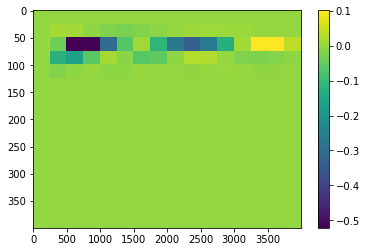

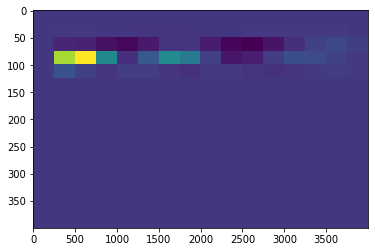

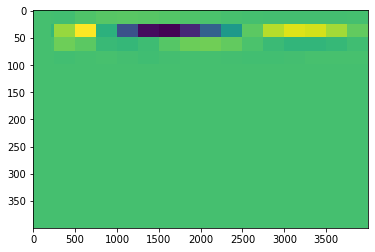

In [30]:
PC = pickle.load(open("output/cs2-only/PC_q-4_t-7.p", "rb"))
plt.imshow(PC[0].T,aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(PC[1].T,aspect='auto')
plt.show()
plt.imshow(PC[2].T,aspect='auto')